In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa
import time

from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Read the file containing cleaned reviews

In [2]:
conn = sqlite3.connect('../8. Amazon_New/final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()

In [3]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


#### Since KNN is a bit slow and requires more RAM, we will use a sample of the dataset.
Since we are sampling the dataset, we will create a balanced dataset containing only 10000 points (5000 positive and 5000 negative)

In [3]:
negative = final[final['Score'] == 0][['Score', 'Time', 'CleanedText']]
positive = final[final['Score'] == 1][['Score', 'Time', 'CleanedText']]
data = pd.concat([negative.iloc[:5000,:], positive.iloc[:5000,:]], axis = 0, ignore_index = True)
## Sort the dataframe on time
data.sort_values('Time', inplace = True)
data.head(10)

,Score,Time,CleanedText
5954,1,961718400,realli good idea final product outstand use de...
5953,1,962236800,receiv shipment could hard wait tri product lo...
7890,1,1081555200,mae ploy sweet chili sauc becom standard condi...
4650,0,1084665600,suppos avoid sugar urinari tract infect
5924,1,1088467200,perfect year round meat dish omaha steak twice...
9942,1,1090972800,one great basic food whatev cat realli mine ex...
939,0,1090972800,cat yet like one littl interest think smell na...
941,0,1090972800,honest say buy varieti look bad smell bad sure...
9927,1,1090972800,accord cat stuff great lick hour eat one love ...
9931,1,1090972800,cat favorit one lick bowl clean whenev get usu...


In [5]:
data.shape

(10000, 3)

In [4]:
# If you do not require some variables, delete them from your main memory
del final, negative, positive

In [7]:
data['Score'].value_counts()

1    5000
0    5000
Name: Score, dtype: int64

### Separate the featues fom the target variable

In [5]:
X = data['CleanedText']
y = data['Score']

### Train Test Split

In [6]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [10]:
X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape

((7000,), (7000,), (3000,), (3000,))

#### Vectorizing the text using TFIDF model

In [7]:
# Create an object of class CountVectorizer
tfidf = TfidfVectorizer()
# Call the fit_transform method on training data
X_train = tfidf.fit_transform(X_train_raw.values)

In [13]:
type(X_train)

scipy.sparse.csr.csr_matrix

**Note:** This is a sparse matrix

In [14]:
X_train.shape

(7000, 11142)

#### This means the size of the vocaulary in the training set is 11142

In [8]:
# Call the transform method on the test dataset
X_test = tfidf.transform(X_test_raw.values)

In [16]:
type(X_test)

scipy.sparse.csr.csr_matrix

In [17]:
X_test.shape

(3000, 11142)

### Column Standardization

In [9]:
# Create an object of StandardScaler
s = StandardScaler(with_mean=False) # Since we are passing sparse matrix
# Call the fit_transform method on training data
X_train = s.fit_transform(X_train)
# Call the transform method on the test dataset
X_test = s.transform(X_test)

## Model Building - Hyperparameter tuning and k-fold Cross validation

In [19]:
start = time.time()
# creating odd list of K for KNN
neighbors = range(1,20,2)

cv_scores = [] # empty list that will hold cv scores

# Try each value of k in the below loop
for k in neighbors:
    # Create an object of the class KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 4 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) k is the one for which error is minimum (or accuracy is maximum)
optimal_k = neighbors[cv_error.index(min(cv_error))]
print('\nThe optimal number of neighbors is', optimal_k)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal number of neighbors is 5
Total time in minutes =  1.014727000395457


Text(0,0.5,'Misclassification Error')

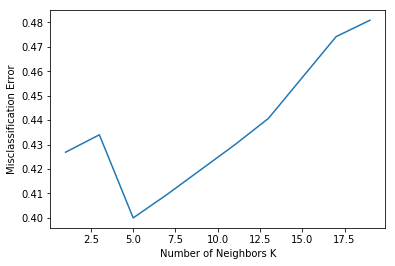

In [20]:
# plot misclassification error vs k 
plt.plot(neighbors, cv_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

### Build the final model with the optimal value of k

In [10]:
clf = KNeighborsClassifier(n_neighbors = optimal_k)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Make the predictions on the test set

In [22]:
y_pred = clf.predict(X_test)

### Calculate test accuracy

In [23]:
acc = accuracy_score(y_test, y_pred) * 100
acc

61.9

### Check the confusion matrix

In [24]:
confusion_matrix(y_test, y_pred)

array([[1035,  548],
       [ 595,  822]], dtype=int64)

#### Refer - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
**Interpretation:**
* 1035 negative reviews classified as negative (true negative)
* 548 positive reviews classified as negative (false negative)
* 595 negative reviews classified as positive (false positive)
* 822 positive reviews classified as positive (true positive)

### Predict Probabilities

In [24]:
# Select a random test point
i = np.random.randint(1,3000)
y_pred = clf.predict(X_test[i])[0]
y_proba = clf.predict_proba(X_test[i])[0]
print("Actual class:",y_test.iloc[i])
print("Predicted class class:",y_pred)
print("Predicted probabilities",y_proba)

Actual class: 0
Predicted class class: 0
Predicted probabilities [0.6 0.4]
